# Генеративно-состязательные сети (Generative Adversarial Networks)

В задании предлагается реализовать GAN, обучить её на MNIST, оценить правдоподобие и сделать выводы.

Необходимая теория приведена ниже.

Актуальная версия доступна по адресу https://github.com/nadiinchi/dl_labs/blob/master/lab_gan.ipynb

## Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x \in \mathbb{R}^D$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. $x = G_\theta(z)$.

Параметры преобразования $G_\theta(z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z))$$

## Оценка логарифма правдоподобия
Для оценки логарифма правдоподобия используется метод Парзеновского окна/ядерного сглаживания (англ. Kernel Density Estimation/Parzen–Rosenblatt window method). Концептуально он заключается в том, что мы сглаживаем модельное распределение, и по этому сглаженному распределению вычисляем правдоподобие модели.

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z)) \approx \frac{1}{Mh^D}\sum_{i=1}^M K\left(\frac{x - G_\theta(z_i)}{h}\right)$$

Здесь $K(x)$ - любое распределение, а $h$ - ширина окна. Тогда выполняется

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{Mh^D}\sum_{j=1}^M K\left(\frac{x_i - G_\theta(z_j)}{h}\right)$$

В генеративно-состязательных сетях для оценки правдоподобия используется стандартное нормальное распределение $K(x) = N(x | 0, I)$. Тогда получаем

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{M}\sum_{j=1}^M \prod_{k=1}^D\frac{1}{\sqrt{2 \pi} \sigma}\exp\left(-\frac{(x_{i,k} - G(z_j)_k)^2}{2\sigma^2}\right)$$

Коэффициент $\sigma$ настраивается на валидационной выборке и с его помощью считается правдоподобие тестовой выборки.

### Загрузка, нормировка и визуалиация данных

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if cuda_output and exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline


In [0]:
USE_CUDA = True   # если есть pytorch с cuda, этот флаг может ускорить обучение

In [0]:
from torchvision import transforms
author_transformation = transforms.Compose([
  transforms.ToTensor(),
  #nn.AvgPool2d(2,2),
])

mnist_dataset = MNIST('mnist', download=True, transform=author_transformation)

val_amount = 5000
test_amount = 10000
train_amount = 45000

train_data, test_data, val_data = torch.utils.data.dataset.random_split(mnist_dataset, [train_amount, test_amount, val_amount])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)


torch.Size([32, 1, 28, 28]) torch.Size([32])


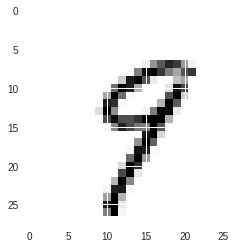

In [22]:
for image, label in val_loader:
    print(image.shape, label.shape)
    plt.imshow(image[0].reshape(28, 28))
    plt.show()
    break

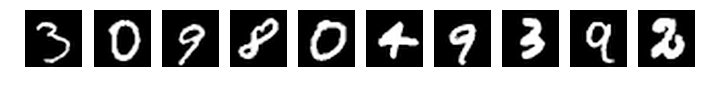

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x, digit_size=28):
    
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        image = x[i].reshape(digit_size, digit_size)
        plt.imshow(image, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

images = np.array([train_data[i][0].numpy() for i in range(10)])
show_images(images, 28)

In [0]:
class Reshape(nn.Module):
    def __init__(self, *args):
        """
        Запоминает размерности, в которые при проходе
        вперед будут переводиться все объекты.
        Например,
            input = torch.zeros(100, 196)
            reshape_layer = Reshape(1, 14, 14)
            reshape_layer(input)
        возвращает тензор размерности (100, 1, 14, 14).
            input = torch.zeros(100, 1, 14, 14)
            reshape_layer = Reshape(-1)
            reshape_layer(input)
        наоборот вернет тензор размерности (100, 196).
        """
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        """
        Возвращает тензор с измененными размерностями объектов.
        Вход: input, FloatTensor или Variable.
        Возвращаемое значение: FloatTensor или Variable.
        """
        return input.view(input.size(0), *self.dims)

In [0]:
class GAN(nn.Module):
    def __init__(self, d):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.eps = 1e-9
        
        # Те, у кого достаточно вычислительных ресурсов, могут попробовать
        # сверточные архитектуры генератора и дискриминатора.
        # Для того, чтобы в рамках одного Sequential переключаться между
        # сверточными и полносвязными слоями, можно использовать Reshape,
        # например:
        # nn.Sequential(
        #     Reshape(1, 14, 14),
        #     nn.Conv2d(1, 6, 5, 2),
        #     nn.LeakyReLU(),
        #     Reshape(6 * 10 * 10) или Reshape(-1)
        # )
        
        # <<Те, у кого достаточно вычислительных ресурсов
        # >> Наш выбор:
            

        self.discriminator = nn.Sequential(
          Reshape(1, 28, 28),
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
          #nn.ReLU(),
          nn.LeakyReLU(0.3),
          
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(num_features=128, eps=self.eps),
          #nn.ReLU(),
          nn.LeakyReLU(0.3),
          Reshape(7*7*128),
            
          nn.Linear(in_features=7*7*128, out_features=1024),
          nn.BatchNorm1d(num_features=1024, eps=self.eps),
          nn.ReLU(),
          nn.LeakyReLU(0.3),  
          nn.Linear(1024, 1),
            
          nn.Sigmoid()
        )
            
        self.generator = nn.Sequential(
          nn.Linear(in_features=self.d, out_features=1024),
          nn.BatchNorm1d(num_features=1024, eps=self.eps),
          nn.ReLU(),
            
          nn.Linear(in_features=1024, out_features=7*7*128),
          nn.BatchNorm1d(num_features=7*7*128, eps=self.eps),
          nn.ReLU(),
            
          Reshape(128, 7, 7),
            
          nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(num_features=64, eps=self.eps),
          nn.ReLU(),
            
          nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            
          nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        z = torch.randn(num_samples, self.d)
        if next(self.parameters()).is_cuda:
            z = z.cuda()
            
        return z

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        noise = self.generate_noise(num_samples)
        return self.generator(noise)

    def discriminator_loss(self, batch):
        """
        Вычисляет значение функции потерь дискриминатора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Variable, скаляр - значение функции потерь
        дискриминатора на данном батче.
        """
        if next(self.parameters()).is_cuda:
            batch = batch.cuda()
          
        batch_score = self.discriminator(batch)
        generated_batch_score = self.discriminator(self.generate_samples(batch.shape[0]))
        
        #clamp(min=0) is exactly ReLU lol
        relu_batch_score = torch.clamp(batch_score, min=self.eps).log().mean() 
        relu_generated_batch_score = torch.clamp(1-generated_batch_score, min=self.eps).log().mean()
        total_loss = -1 * (relu_batch_score+relu_generated_batch_score)
        return total_loss

    def generator_loss(self, batch_size):
        """
        Вычисляет значение функции потерь генератора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Variable, скаляр - значение функции потерь
        генератора на данном батче.
        """
        generated_batch_score = self.discriminator(self.generate_samples(batch_size))
        relu_generated_batch_score = torch.clamp(1-generated_batch_score, min=self.eps).log().mean()
        return relu_generated_batch_score

In [0]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Varibale - матрица размера n x k.
    Возвращаемое значение: Variable, вектор длины n.
    """
    eps = 1e-9
    max_mtx = torch.max(mtx, dim=-1)[0].view(-1,1)
    return torch.log( torch.mean(torch.exp(mtx - max_mtx), dim=1) + eps ) + max_mtx

In [0]:
def log_likelihood(model, num_samples=512, batch_size=4, num_batches=20):
    """
    Возвращает оценку логарифма правдоподобия модели GAN методом
    Парзеновского окна со стандартным нормальным ядром.
    Подсказка: с аргументами по умолчанию метод должен работать несколько
    секунд, чтобы не замедлять обучение.
    Подсказка: sigma должна настраиваться по валидационной выборке, а
    правдоподобие считаться по тестовой.
    Подсказка: вместо sigma можно настраивать log_sigma.
    Подсказка: для настойки sigma допустимо использовать как перебор по сетке,
    так и другие методы опимизации.
    Вход: mtx, GAN - обученная модель.
    Вход: num_samples, int - число сэмплов z для оценки правдоподобия.
    Вход: batch_size, int - размер батча валидационной или тестовой выборки.
    Вход: num_batches, int - число батчей, на которых настраивается sigma или
    считается правдоподобие.
    Возвращаемое значение: float (не Variable!) - оценка логарифма правдоподобия.
    """
    IMAGE_SIZE = 28
    eps = 1e-9
    
    validate_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    samples = model.generate_samples(num_samples)
    samples = samples.view(1, num_samples, -1).cpu().data
    
    def loglikehood_on_sigma(sigma):
        loglikehood_validation = 0
        for ix, (batch, labels) in enumerate(validate_loader):
            if ix >= num_batches:
#                 print("Finished iteration")
                return loglikehood_validation / num_batches
              
            batch = batch.view(-1, 1, IMAGE_SIZE * IMAGE_SIZE)
            loglikehood_validation += log_mean_exp(torch.sum((-(batch-samples)**2) /(2*sigma**2) - np.log(np.sqrt((2*np.pi)) * sigma + eps), dim=2)).mean()          
    
    sigmas = np.logspace(-2,0.5, num=25)
    best_sigma_ix = np.array(list(map(loglikehood_on_sigma, sigmas))).argmax()
    best_sigma  = sigmas[best_sigma_ix]
    
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    loglikehood_test = 0
    for ix, (batch, labels) in enumerate(test_loader):
        if ix >= num_batches:
#             print("Finished iteration")
            return loglikehood_test / num_batches
          
        batch = batch.view(-1, 1, IMAGE_SIZE * IMAGE_SIZE)
        loglikehood_test = loglikehood_test + log_mean_exp(torch.sum((-(batch - samples)**2) / (2 * best_sigma * best_sigma) - np.log(np.sqrt((2*np.pi)) * best_sigma + eps), dim=2)).mean()

In [0]:
def train_model(model, k=1, batch_size=64, num_epochs=100, learning_rate=2e-4):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: k, int - число итераций оптимизации дискриминатора на итерацию оптимизации
    генератора.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'generator_losses' - список значений функции потерь генератора,
    'discriminator_losses' - список значений функции потерь дискриминатора.
    """
    gd_generator = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    gd_discriminator = optim.Adam(model.discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    total_batches = len(dataloader)

    generator_losses = [0]
    discriminator_losses = [0]
    log_likelihoods = []

    if USE_CUDA:
        model = model.cuda()

    ll = log_likelihood(model)
    log_likelihoods.append(ll)
    print('Log-likelihood', ll, flush=True)

    for epoch in range(num_epochs):
        for i, (batch, _) in enumerate(dataloader):
            if USE_CUDA:
                batch = batch.cuda()
            gd_discriminator.zero_grad()
            loss = model.discriminator_loss(batch)
            discriminator_losses.append(loss.data.cpu().item())
            loss.backward()
            gd_discriminator.step()
            
            if ((i+1) % k) == 0:
                gd_generator.zero_grad()
                loss = model.generator_loss(batch_size)
                generator_losses.append(loss.data.cpu().item())     
                loss.backward()
                gd_generator.step()
                       
            if ((i + 1) % 100) == 0:
                print('\rEpoch:', epoch, 'G_loss:', generator_losses[-1],
                      'D_loss:', discriminator_losses[-1],
                      'Batch', i + 1, 'of', total_batches,
                      ' ' * 10, end='', flush=True)
        print(flush=True)
        ll = log_likelihood(model)
        log_likelihoods.append(ll)
        print('Log-likelihood', ll, flush=True)

    return {
        'model': model.cpu(),
        'generator_losses': generator_losses,
        'discriminator_losses': discriminator_losses,
        'log_likelihoods': log_likelihoods
    }

In [29]:
%time log_likelihood(GAN(2))

CPU times: user 6.37 s, sys: 257 ms, total: 6.63 s
Wall time: 6.64 s


tensor(-539.7734)

### Обучение модели

In [30]:
%time gan_model_d2 = train_model(GAN(2), k=1, num_epochs=25, learning_rate=2e-4, batch_size=128)

Log-likelihood tensor(-529.5187)
Epoch: 0 G_loss: -0.16114366054534912 D_loss: 0.4113525152206421 Batch 300 of 352           
Log-likelihood tensor(-422.1612)
Epoch: 1 G_loss: -0.06469107419252396 D_loss: 0.14255712926387787 Batch 300 of 352           
Log-likelihood tensor(-251.5094)
Epoch: 2 G_loss: -0.04786330461502075 D_loss: 0.13740362226963043 Batch 300 of 352           
Log-likelihood tensor(-81.8827)
Epoch: 3 G_loss: -0.07714367657899857 D_loss: 0.26317697763442993 Batch 300 of 352           
Log-likelihood tensor(-117.5477)
Epoch: 4 G_loss: -0.05705439671874046 D_loss: 0.2285158634185791 Batch 300 of 352           
Log-likelihood tensor(-135.5524)
Epoch: 5 G_loss: -0.08128941059112549 D_loss: 0.2925543189048767 Batch 300 of 352           
Log-likelihood tensor(-85.5346)
Epoch: 6 G_loss: -0.16246648132801056 D_loss: 0.5398952960968018 Batch 300 of 352           
Log-likelihood tensor(-150.7940)
Epoch: 7 G_loss: -0.13313180208206177 D_loss: 0.3149624764919281 Batch 300 of 352   

In [31]:
%time gan_model_d10 = train_model(GAN(10), k=1, num_epochs=25, learning_rate=2e-4, batch_size=64)

Log-likelihood tensor(-527.6061)
Epoch: 0 G_loss: -0.23541155457496643 D_loss: 0.500710129737854 Batch 700 of 704           
Log-likelihood tensor(28.7368)
Epoch: 1 G_loss: -0.41103529930114746 D_loss: 0.8529189825057983 Batch 700 of 704           
Log-likelihood tensor(38.1917)
Epoch: 2 G_loss: -0.6181685924530029 D_loss: 0.8454549312591553 Batch 700 of 704           
Log-likelihood tensor(29.2362)
Epoch: 3 G_loss: -0.4415161907672882 D_loss: 0.824211597442627 Batch 700 of 704           
Log-likelihood tensor(-44.8998)
Epoch: 4 G_loss: -0.49163439869880676 D_loss: 0.8903316259384155 Batch 700 of 704           
Log-likelihood tensor(74.3027)
Epoch: 5 G_loss: -0.6076967716217041 D_loss: 1.2555993795394897 Batch 700 of 704           
Log-likelihood tensor(94.0175)
Epoch: 6 G_loss: -0.5017001628875732 D_loss: 0.9376310706138611 Batch 700 of 704           
Log-likelihood tensor(76.2034)
Epoch: 7 G_loss: -0.3746770918369293 D_loss: 0.66350257396698 Batch 700 of 704           
Log-likelihood

In [32]:
%time gan_model_d100 = train_model(GAN(100), k=1, num_epochs=25, learning_rate=2e-4, batch_size=64)

Log-likelihood tensor(-520.5205)
Epoch: 0 G_loss: -0.07209053635597229 D_loss: 0.19327887892723083 Batch 700 of 704           
Log-likelihood tensor(-154.2721)
Epoch: 1 G_loss: -0.12479051202535629 D_loss: 0.5452276468276978 Batch 700 of 704           
Log-likelihood tensor(-44.9534)
Epoch: 2 G_loss: -0.3695177435874939 D_loss: 0.5377512574195862 Batch 700 of 704           
Log-likelihood tensor(10.9613)
Epoch: 3 G_loss: -0.3327203094959259 D_loss: 0.42059797048568726 Batch 700 of 704           
Log-likelihood tensor(34.9303)
Epoch: 4 G_loss: -0.19337648153305054 D_loss: 0.5085493326187134 Batch 700 of 704           
Log-likelihood tensor(68.7397)
Epoch: 5 G_loss: -0.4158325791358948 D_loss: 0.6933223009109497 Batch 700 of 704           
Log-likelihood tensor(49.1932)
Epoch: 6 G_loss: -0.17838981747627258 D_loss: 0.4156091809272766 Batch 700 of 704           
Log-likelihood tensor(63.9882)
Epoch: 7 G_loss: -0.237526074051857 D_loss: 0.30390265583992004 Batch 700 of 704           
Log-l

### Анализ результатов

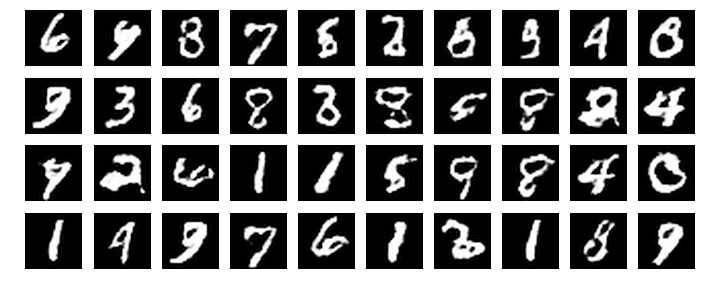

In [33]:
show_images(gan_model_d2['model'].generate_samples(40).data.numpy(), 28)

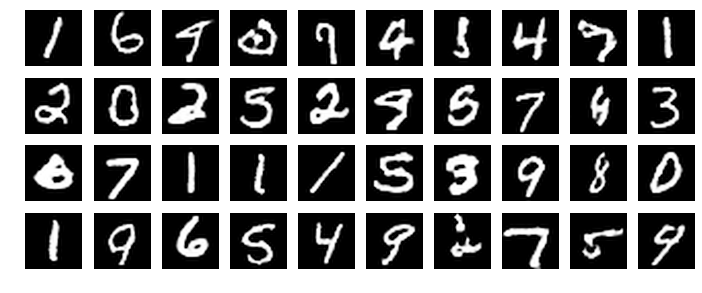

In [34]:
show_images(gan_model_d10['model'].generate_samples(40).data.numpy())

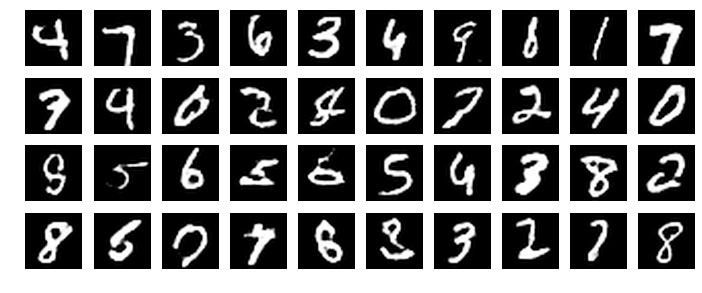

In [35]:
show_images(gan_model_d100['model'].generate_samples(40).data.numpy())

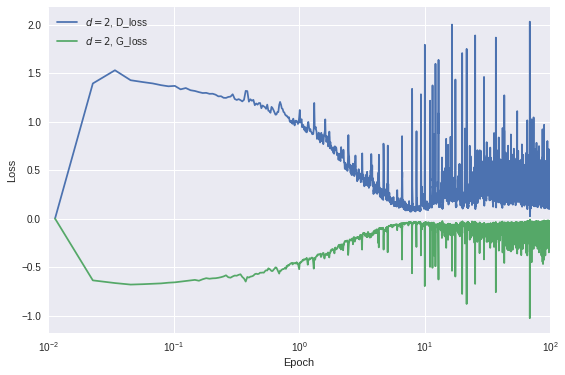

In [36]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, D_loss', 'discriminator_losses', gan_model_d2),
    ('$d = 2$, G_loss', 'generator_losses', gan_model_d2),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

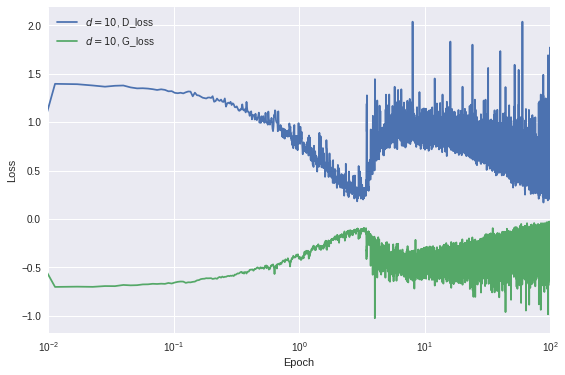

In [37]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 10$, D_loss', 'discriminator_losses', gan_model_d10),
    ('$d = 10$, G_loss', 'generator_losses', gan_model_d10),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

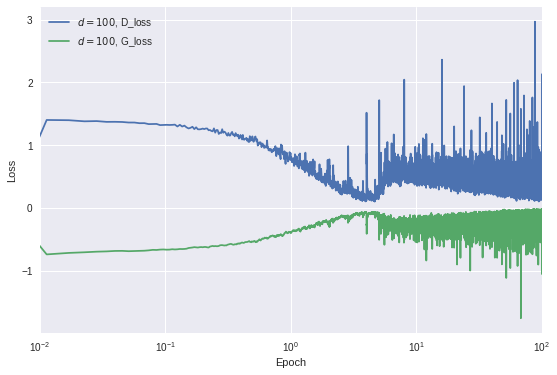

In [38]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 100$, D_loss', 'discriminator_losses', gan_model_d100),
    ('$d = 100$, G_loss', 'generator_losses', gan_model_d100),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

In [39]:
%time log_likelihood(gan_model_d2['model'], num_samples=10000)

CPU times: user 4min 3s, sys: 4.04 s, total: 4min 8s
Wall time: 4min 8s


tensor(21.0557)

In [40]:
%time log_likelihood(gan_model_d10['model'], num_samples=10000)

CPU times: user 3min 54s, sys: 2.69 s, total: 3min 57s
Wall time: 3min 57s


tensor(213.9530)

In [41]:
%time log_likelihood(gan_model_d100['model'], num_samples=10000)

CPU times: user 4min 36s, sys: 3.07 s, total: 4min 39s
Wall time: 4min 39s


tensor(223.9774)

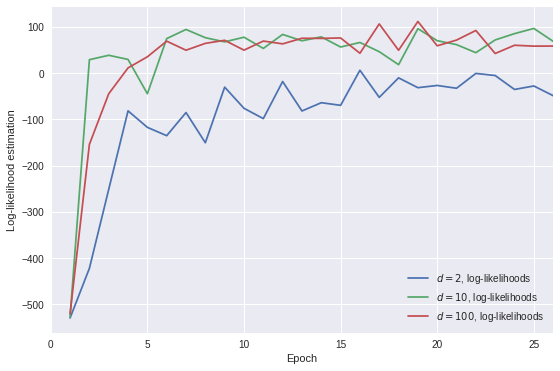

In [42]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, log-likelihoods', 'log_likelihoods', gan_model_d2),
    ('$d = 10$, log-likelihoods', 'log_likelihoods', gan_model_d10),
    ('$d = 100$, log-likelihoods', 'log_likelihoods', gan_model_d100),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data)))
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы
Место для ваших выводов, наблюдений, гипотез.

Был попробован GAN со сверточной архитектурой - даже на на небольшом числе повторенией сеть учится создавать рукописный датаест приемлемого для обучения качества 

ReLu приходится заменять на LeakyRelu - в это архитектуре он гораздо лучше работает